# Jenn Wong
jennwong@berkeley.edu

Data was gathered from Everlane Mode SQL database from running

select * from {database};

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

from collections import Counter

/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
users_df = pd.read_csv('data/users.csv')
orders_df = pd.read_csv('data/orders.csv')
products_df = pd.read_csv('data/products.csv')

In [3]:
# this is a string and should be date-time for easier analysis
users_df.discovery_time = pd.to_datetime(users_df.discovery_time)
users_df.head() 

,user_id,discovery_channel_category,discovery_channel,discovery_time,discovery_platform,location,gender
0,1957598,paid,other,2017-05-10 07:23:23,desktop,US,female
1,1771115,paid,affiliate,2017-02-15 16:33:02,mobile,US,female
2,1489936,direct,NaN,2016-09-13 16:07:53,desktop,US,female
3,2356025,paid,search,2017-10-12 17:13:53,desktop,US,female
4,1463297,organic search,NaN,2016-08-17 07:06:25,desktop,international,female


In [4]:
orders_df.completed_at = pd.to_datetime(orders_df.completed_at)
orders_df.head()

,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category
0,14134747,2874138,2016-12-29 14:54:22,1444626,1,25.0,447,other,paid
1,17240079,3506498,2017-09-05 19:00:51,1125825,1,68.0,944,search,paid
2,20017564,4020991,2017-12-27 17:41:00,2521400,1,88.0,890,search,paid
3,19281489,3858476,2017-12-01 18:53:11,2222476,1,62.0,640,other,paid
4,15018380,3047663,2017-03-26 15:38:13,1854949,1,100.0,650,affiliate,paid


In [5]:
products_df.launch_date = pd.to_datetime(products_df.launch_date)
products_df.head()

,style_id,style,category,launch_date
0,592,The Premium Wool Flannel Pinstripe Track Pant,Bottoms,2016-09-19
1,572,The Luxe Drape Cropped Scoop-Neck Tee,Knit Tops,2016-07-26
2,645,The Cashmere Cardigan,Sweaters,2016-10-10
3,435,The Modern Flannel Shirt,Shirting,2016-02-25
4,874,The Pleated Midi Skirt,Bottoms,2017-08-24


## Question 1: New Product Launches

1. How would you measure the strength of a new product?
2. Based on this methodology, how would you summarise the recent trends of Everlane launch performance? Please support your answer with data.
3. What are the areas of opportunity when it comes to new launches?


I will be defining the 'strength' of the new product as number of sales in the first two weeks of launch (because I know that Everlane releases new products every week). This will allow me to see how it performs as a 'new product' as well as an 'old-er product' and identify seasonal trends (if any) in the week.

In order to answer this question, I need to get metadata on the products that were ordered. I will be joining the orders_df with the products_df on 'style_id' in order to get the data that I need.

In [6]:
detailed_orders = pd.merge(orders_df, products_df, how='left', on='style_id')
detailed_orders.head()

,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category,style,category,launch_date
0,14134747,2874138,2016-12-29 14:54:22,1444626,1,25.0,447,other,paid,The Pima Stretch Mid-Sleeve,Knit Tops,2016-01-26
1,17240079,3506498,2017-09-05 19:00:51,1125825,1,68.0,944,search,paid,The Cotton Turtleneck,Sweaters,2017-08-10
2,20017564,4020991,2017-12-27 17:41:00,2521400,1,88.0,890,search,paid,The Silk Long-Sleeve Blouse,Woven Tops,2017-09-14
3,19281489,3858476,2017-12-01 18:53:11,2222476,1,62.0,640,other,paid,The Ribbed Wool-Cashmere Sleeveless Turtleneck,Sweaters,2016-10-24
4,15018380,3047663,2017-03-26 15:38:13,1854949,1,100.0,650,affiliate,paid,The Cashmere Crew,Sweaters,2016-10-03


I could have done this in SQL too with the following query:

```sql
SELECT orders.*, products.style, products.category, products.lauch_date FROM orders 
  LEFT JOIN products ON orders.style_id=products.style_id;
```


In [7]:
time_period = 14 # this is the number of days after pdt launch that I care about

detailed_orders['time_since_launch'] = (detailed_orders.completed_at - detailed_orders.launch_date)


# i only care about the days since launch and not such a high resolution
def get_days(date_time_object):
    """
    this function takes a datetime object and returns the days
    """
    return date_time_object.days

detailed_orders['days_since_launch'] = detailed_orders.time_since_launch.apply(get_days)

# I am creating a mask for orders made within the time period i'm interested in.
# sanity check, I know that all orders are at least 0 days since launch. there are some errors in the data though... 
recent_mask = (detailed_orders.days_since_launch <= time_period) & (detailed_orders.days_since_launch >0)

new_orders = detailed_orders[recent_mask]

print(f'I started with {len(detailed_orders)} number of orders. I now have {len(new_orders)} rows of recent orders')
# len(new_orders

new_orders.head()

I started with 43548 number of orders. I now have 4327 rows of recent orders


,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category,style,category,launch_date,time_since_launch,days_since_launch
9,12912030,2563686,2016-10-10 00:34:32,1333122,1,100.0,642,affiliate,paid,The Cashmere Crew,Sweaters,2016-10-03,7 days 00:34:32,7
29,14599945,2973712,2017-02-15 06:11:10,1769008,1,68.0,715,affiliate,paid,The Wide Leg Crop Pant,Bottoms,2017-02-14,1 days 06:11:10,1
37,14687198,2989227,2017-02-24 11:59:12,1732638,1,68.0,715,other,paid,The Wide Leg Crop Pant,Bottoms,2017-02-14,10 days 11:59:12,10
44,16116627,3290378,2017-06-18 05:40:10,656605,1,25.0,934,search,paid,Human Pride Unisex Tank in Double Print,Knit Tops,2017-06-05,13 days 05:40:10,13
48,18280552,3679979,2017-10-21 17:49:11,2380929,1,155.0,933,search,paid,The Waffle Knit Cashmere Square Crew,Sweaters,2017-10-12,9 days 17:49:11,9


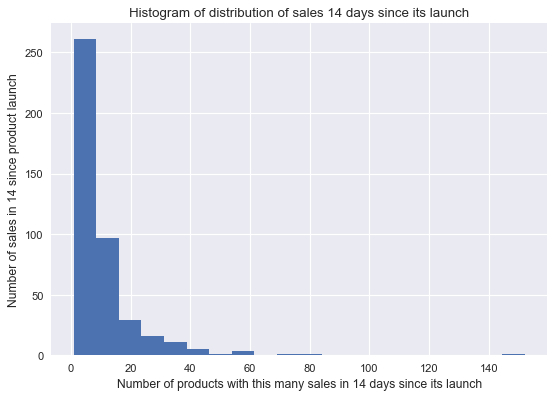

In [8]:
# so now I need to find the count of sales for each day over two weeks after launch for each product

sale_count = new_orders['style_id'].value_counts().reset_index()
sale_count.rename(columns = {
    'index': 'style_id',
    'style_id': 'sale_count'
}, inplace = True)
sale_count.head()

plt.figure(dpi = 80)
plt.hist(sale_count.sale_count, bins = 20)
plt.xlabel(f'Number of products with this many sales in {time_period} days since its launch')
plt.ylabel(f'Number of sales in {time_period} since product launch')
plt.title(f'Histogram of distribution of sales {time_period} days since its launch')
plt.show();

This shows me that there are 'strong' products, but I want to quantitatively identify which products they are.

I know that there is the 80/20 rule in which 20% of the products drive 80% of the revenue...


Source: https://www.forbes.com/sites/davelavinsky/2014/01/20/pareto-principle-how-to-use-it-to-dramatically-grow-your-business/#4b5451313901

/Users/jennwon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


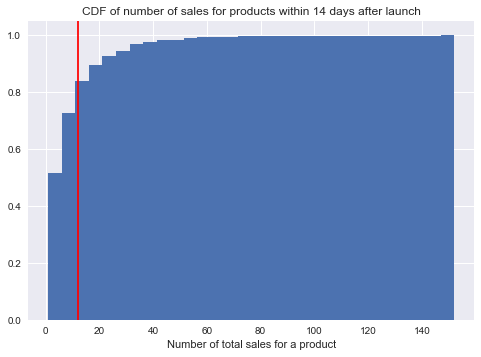

In [9]:
plt.hist(new_orders['style_id'].value_counts(), normed = True, cumulative= True, bins = 30)
plt.axvline(x=12,ymin=0,ymax=1,color='r')
plt.title(f'CDF of number of sales for products within {time_period} days after launch')
plt.xlabel('Number of total sales for a product')
plt.show(); 

It seems that these products have approx. 12 sales or more. I will be using that as a feature to identify the categories of these products

In [10]:
popular_styles_id = sale_count[sale_count.sale_count >=12]['style_id'].unique()
popular_mask = products_df.style_id.isin(popular_styles_id)

top_categories = sorted(Counter(products_df[popular_mask]['category']).items(), key = lambda x: x[1], reverse = True)

# top category defined as the n most frequent categories sales
top_n_categories = 6
top_categories = [category for category, _ in top_categories[:top_n_categories]]

In [11]:
# add a column for total sale of items in first 14 days since its launch
new_orders = pd.merge(new_orders, sale_count, how = 'left', on = 'style_id')

# i only care about these columns to do my analysis for recent trends
trends_df = new_orders[['style_id', 'category', 'launch_date', 'sale_count']]
trends_df.drop_duplicates(inplace = True)

/Users/jennwon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/jennwon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


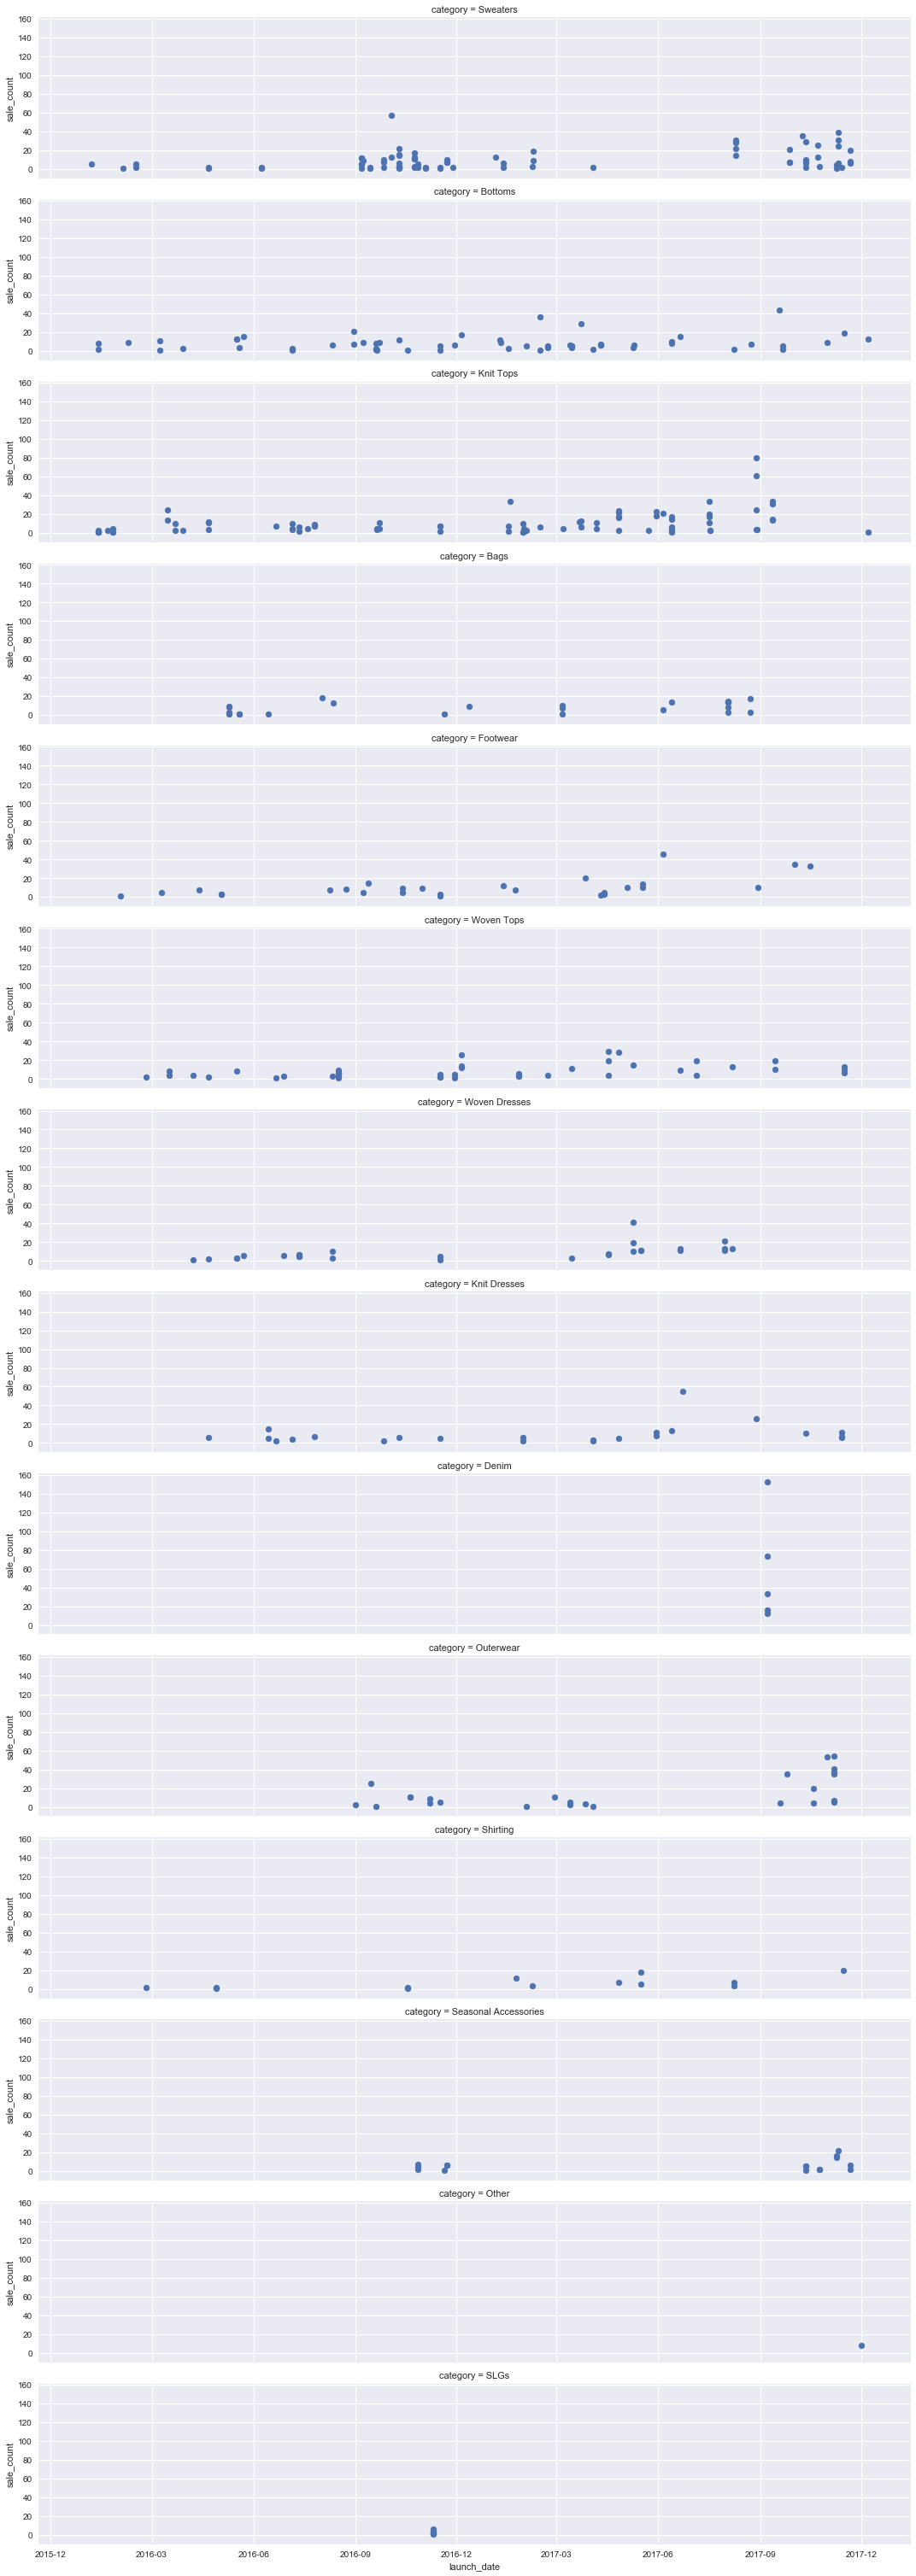

In [12]:
import seaborn as sns

g = sns.FacetGrid(data = trends_df, row = 'category', height =3, sharex = True, aspect = 5)
g = g.map(plt.scatter, "launch_date", "sale_count")

Comparing the list of categories that emerged as consistently 'strong' products to all of the different categories, we see that most of the 'strong' products are most appropriate for winter/colder climates (e.g. knits, outerwear).

I also notice that bottoms, and woven tops consistently produces sales throughout the year.

The release of denim products was very successful!

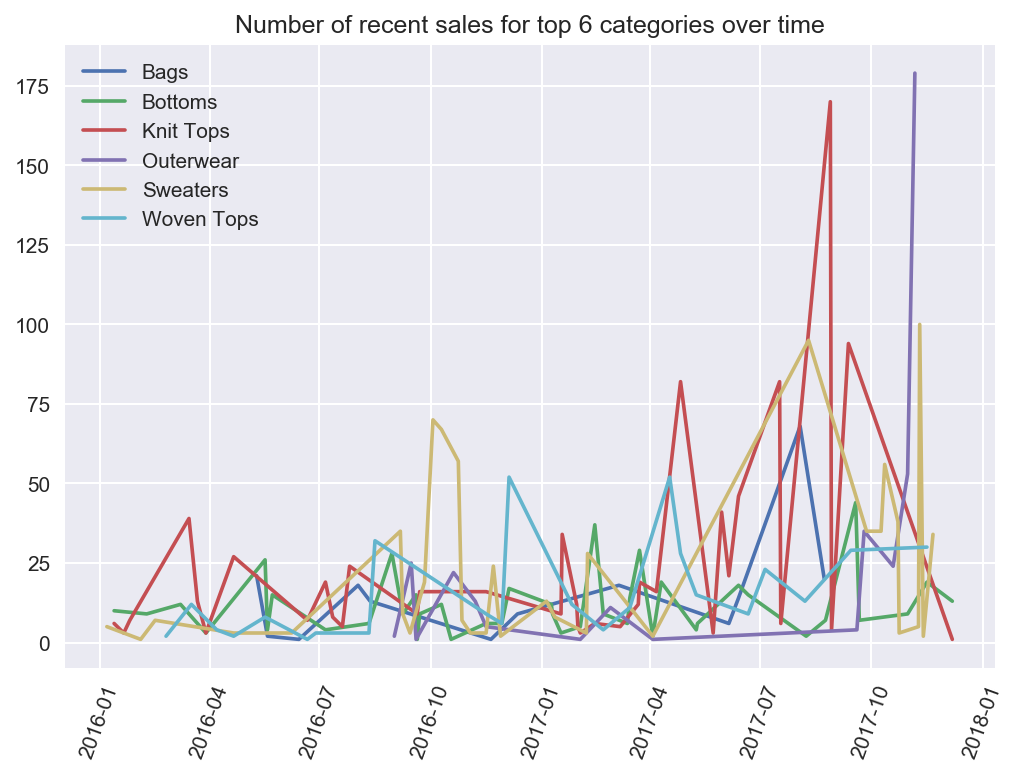

the complete list of categories: 
 ['Denim', 'Knit Dresses', 'Sweaters', 'Woven Tops', 'Seasonal Accessories', 'Other', 'Knit Tops', 'Footwear', 'Bags', 'Bottoms', 'SLGs', 'Outerwear', 'Shirting', 'Woven Dresses']


In [13]:
# group by the category and sum the sale_counts and graph over time
plt.figure(dpi = 150)
legend_labels = []

for name, group in trends_df.groupby(['category']):
    if name in top_categories:
        legend_labels.append(name)
        category_df = group.groupby('launch_date')['sale_count'].sum().reset_index()
        plt.plot(category_df.launch_date, category_df.sale_count)
#         break
plt.title(f'Number of recent sales for top {len(top_categories)} categories over time')
plt.legend(legend_labels)
plt.xticks(rotation = 70)
plt.show();

print(f'the complete list of categories: \n {list(set(new_orders.category))}')

Outerwear and Knit Tops has some of the highest peaks in sales

I think it would be interesting to see what is the most popular category over each month.

In [14]:
# i am also interested to see which product and corresponding category does best in each month logged

trends_df.head(10)

,style_id,category,launch_date,sale_count
0,642,Sweaters,2016-10-03,57
1,715,Bottoms,2017-02-14,36
3,934,Knit Tops,2017-06-05,21
4,933,Sweaters,2017-10-12,29
5,916,Bags,2017-08-23,17
6,869,Footwear,2017-06-05,46
7,759,Woven Tops,2017-04-17,19
9,810,Woven Dresses,2017-05-09,41
10,545,Knit Tops,2016-07-06,4
12,873,Woven Dresses,2017-07-31,13


In [15]:
def get_month(datetime_object):
    return datetime_object.month, datetime_object.year

trends_df['launch_month'] = trends_df.launch_date.apply(get_month)
trends_df.head()

/Users/jennwon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,style_id,category,launch_date,sale_count,launch_month
0,642,Sweaters,2016-10-03,57,"(10, 2016)"
1,715,Bottoms,2017-02-14,36,"(2, 2017)"
3,934,Knit Tops,2017-06-05,21,"(6, 2017)"
4,933,Sweaters,2017-10-12,29,"(10, 2017)"
5,916,Bags,2017-08-23,17,"(8, 2017)"


In [16]:
best_product_by_month = pd.DataFrame(trends_df.sort_values('sale_count', ascending = False).groupby('launch_month').first()).reset_index()
best_product_by_month.sort_values('launch_date', inplace = True)
best_product_by_month

,launch_month,style_id,category,launch_date,sale_count
0,"(1, 2016)",465,Bottoms,2016-01-13,8
2,"(2, 2016)",713,Bottoms,2016-02-09,9
4,"(3, 2016)",475,Knit Tops,2016-03-15,25
6,"(4, 2016)",497,Knit Tops,2016-04-21,12
8,"(5, 2016)",503,Bottoms,2016-05-23,15
10,"(6, 2016)",533,Knit Dresses,2016-06-14,15
12,"(7, 2016)",544,Knit Tops,2016-07-06,10
14,"(8, 2016)",610,Bottoms,2016-08-30,21
16,"(9, 2016)",597,Outerwear,2016-09-15,25
18,"(10, 2016)",642,Sweaters,2016-10-03,57


In [17]:
Counter(best_product_by_month.category) # counts how many times each category is the top performer each month

Counter({'Bottoms': 7,
         'Denim': 1,
         'Knit Dresses': 2,
         'Knit Tops': 6,
         'Outerwear': 3,
         'Sweaters': 2,
         'Woven Dresses': 1,
         'Woven Tops': 2})

In [18]:
print(f'The average number of sales for monthly top performer: {np.mean(best_product_by_month.sale_count.values)}')

The average number of sales for monthly top performer: 35.125


Some areas of opportunity regarding launching new products:
1. Collecting more data to validate or refute claim that winter products are more valued because of quality
2. Are most of the customers driving the revenue repeat customers or new customers
3. How did they get to the site? What facilitated them to browse products and ultimately check out?
4. i would be interested to know which price_bin does the best for each category to optimize on customer satisfaction

If I had more time, I would try to model this information by figuring out which features will make a product a 'success' as defined by having higher than average total sales. i think it would also be interesting to look at the projections for a product and compare it to how well it actually did

I wonder if the weekday of when products are launched will affect sales

## Question 2: New Customer Acquisition

1. How would you measure the 'strength' of new customer acquisition?
2. Based on this measurement, what would you say are the most valuable channels?
3. What additional data would you like to look at to measure acqusition performance?

I would measure the 'strength' of new customer acquisition as how many items they've ordered in total from everlane

I am able to join the two tables in SQL with the following query:
```sql
SELECT o.*, u.*
FROM recruiting.orders o
LEFT JOIN recruiting.users u ON o.user_id = u.user_id;


```


In [19]:
user_orders = pd.merge(orders_df, users_df, how='left', on='user_id')
user_orders.head()

,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category,discovery_channel_category,discovery_channel,discovery_time,discovery_platform,location,gender
0,14134747,2874138,2016-12-29 14:54:22,1444626,1,25.0,447,other,paid,paid,display,2016-07-21 13:33:43,desktop,US,female
1,17240079,3506498,2017-09-05 19:00:51,1125825,1,68.0,944,search,paid,email,NaN,2017-01-30 11:27:16,mobile,international,female
2,20017564,4020991,2017-12-27 17:41:00,2521400,1,88.0,890,search,paid,paid,search,2017-11-14 10:38:21,mobile,US,female
3,19281489,3858476,2017-12-01 18:53:11,2222476,1,62.0,640,other,paid,email,NaN,2017-06-08 11:27:58,desktop,US,female
4,15018380,3047663,2017-03-26 15:38:13,1854949,1,100.0,650,affiliate,paid,paid,affiliate,2017-03-26 15:28:26,desktop,US,NaN


I'd like to know which discovery channel category is able to acquire the most fruitful customers.

In [30]:
order_numbers = user_orders[['user_id', 'order_id']].drop_duplicates().groupby('user_id').count().reset_index()
order_numbers.rename(columns = {'order_id': 'order_counts'}, inplace = True)
order_numbers.head()

,user_id,order_counts
0,2826,2
1,3275,1
2,5782,1
3,6161,4
4,8746,2


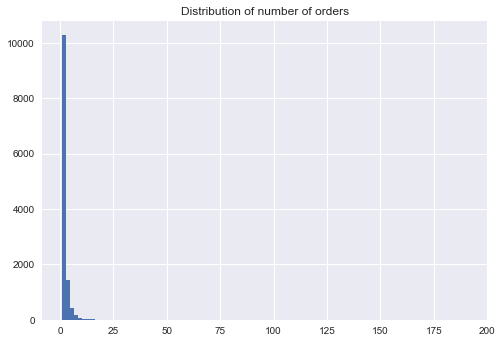

In [31]:
plt.hist(order_numbers.order_counts, bins = 100)
plt.title('Distribution of number of orders')
# plt.xlim(0,25)
plt.show();

There are a lot of users that make only a handleful of purchases aka lots of weak customers

In [32]:
order_numbers = pd.merge(users_df, order_numbers, how = 'left', on = 'user_id')
order_numbers.order_counts.fillna(0, inplace = True)

order_numbers.head()

,user_id,discovery_channel_category,discovery_channel,discovery_time,discovery_platform,location,gender,order_counts
0,1957598,paid,other,2017-05-10 07:23:23,desktop,US,female,1.0
1,1771115,paid,affiliate,2017-02-15 16:33:02,mobile,US,female,0.0
2,1489936,direct,NaN,2016-09-13 16:07:53,desktop,US,female,2.0
3,2356025,paid,search,2017-10-12 17:13:53,desktop,US,female,0.0
4,1463297,organic search,NaN,2016-08-17 07:06:25,desktop,international,female,0.0


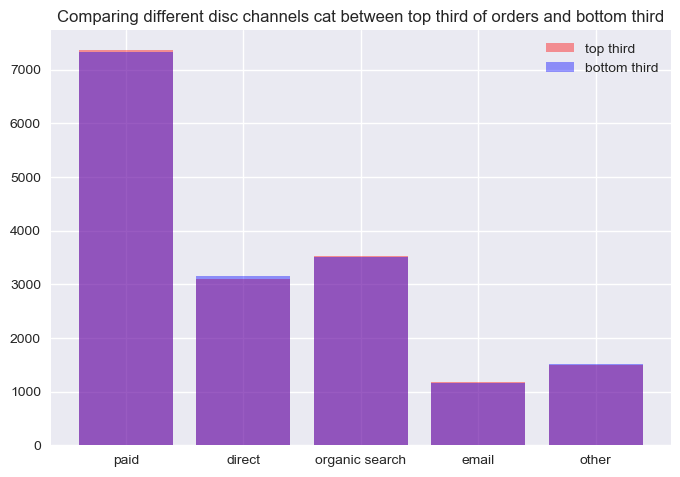

In [33]:
# what if i compared the frequency of the disc channels in the top third to the bottom third 
# to see if there is some signal
order_numbers.discovery_channel.fillna(order_numbers.discovery_channel_category, inplace = True)


# recall that this is already sorted by the number of total orders of each user
top_third = Counter(order_numbers[:len(order_numbers)//3].discovery_channel_category)
bottom_third = Counter(order_numbers[len(order_numbers)//3 *2:].discovery_channel_category)


plt.figure(dpi = 100)
plt.bar(top_third.keys(), top_third.values(), alpha = 0.4, color = 'r')
plt.bar(bottom_third.keys(), bottom_third.values(), alpha = 0.4, color = 'b')

plt.legend({
    'top third': 'r',
    'bottom third': 'b'
})
plt.title('Comparing different disc channels cat between top third of orders and bottom third')
# plt.x_ticks(top_third.keys())
plt.show();

##### I also know that paid can be broken down even further so I want to make sure there are no hidden signals there

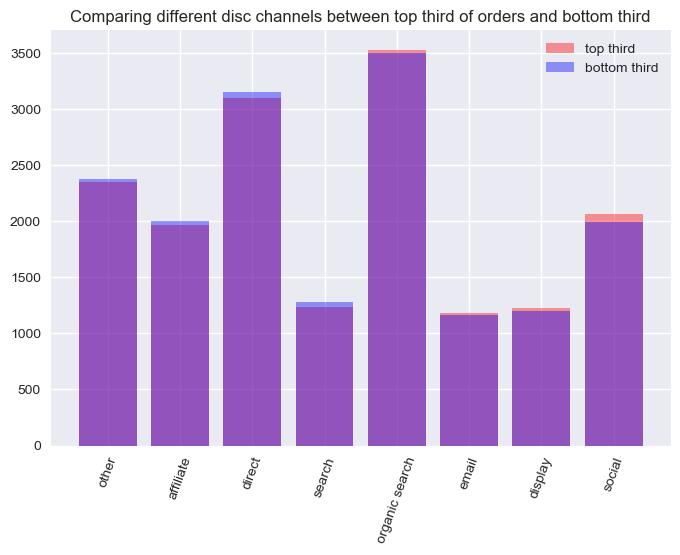

In [34]:
top_third = Counter(order_numbers[:len(order_numbers)//3].discovery_channel)
bottom_third = Counter(order_numbers[len(order_numbers)//3 * 2:].discovery_channel)

# paid has one entry for both of these buckets that i'm going to remove because it's not supposed to be there
top_third.pop('paid', None)
bottom_third.pop('paid', None)

plt.figure(dpi = 100)
plt.bar(top_third.keys(), top_third.values(), alpha = 0.4, color = 'r')
plt.bar(bottom_third.keys(), bottom_third.values(), alpha = 0.4, color = 'b')
plt.xticks(rotation = 70)
plt.legend({
    'top third': 'r',
    'bottom third': 'b'
})
plt.title('Comparing different disc channels between top third of orders and bottom third')
plt.show();

# why is there one user in the paid for top and bottom? there shouldnt be any 'paid' since it's broken down further

In [35]:
# ok cool now that I know that there are clear winners, there are different ways of evaluating how well something did
# i can talk about raw difference or i can talk about relative difference

campaigns = pd.DataFrame(data = [top_third, bottom_third]).transpose()
campaigns.rename(columns = {
    0: 'top_third',
    1: 'bottom_third'
    
}, inplace = True)

In [36]:
campaigns['abs_difference'] = campaigns.top_third - campaigns.bottom_third
campaigns['rel_difference'] = (campaigns.top_third - campaigns.bottom_third) / campaigns[['top_third','bottom_third']].min(axis = 1)
campaigns.sort_values('rel_difference')

,top_third,bottom_third,abs_difference,rel_difference
search,1233,1278,-45,-0.036496
direct,3099,3155,-56,-0.018070
affiliate,1965,1998,-33,-0.016794
other,2353,2373,-20,-0.008500
organic search,3526,3502,24,0.006853
email,1181,1160,21,0.018103
display,1230,1203,27,0.022444
social,2065,1991,74,0.037167


Social, and displace does well in absolute and relative difference.

I think it's interesting to see that direct organic search more power customers than email in terms of absolute difference, but the opposite is true when you look at relative difference.



3. What additional data would you like to look at to acquisition performance?

I see that social channel does well to generate users in the top third of sales. I would like to know which influencers are resposible for the traffic and which campaign collaboration worked the best and why so I can try to repllicate the success

Additionally, I would want to see what customers are searching for, and compare that to what they ultimately bought which i can do rn with the data at hand. I would also like to see which displays did well so I can identify what about them made them do well so I can replicate the success and better understand my users/demographic. 

## Question 3: Customer segments

1. Our marketing team is interested in creating a new email campaign focused on
“Shoe (Footwear) Lovers”. Using the data at hand, what is a way that we can
identify shoe lovers?
2. Let’s say we wanted to generalize this campaign to every category in our product
catalog (i.e. Shoe Lovers, Sweater Lovers, etc.). Please write code that will
generate three lists of user_ids: one of Shoe (Footwear) Lovers, one of Sweater
Lovers, and one of Knit Top Lovers. Bonus points if you can generalize this
across all categories.

1. A naive way to identify 'shoe lovers' would be to see who orders the most shoes.
2. Another way would be to see of all the things the person has ordered, who had the high prop of shoes.

In [27]:
detailed_orders.head()

,line_item_id,order_id,completed_at,user_id,quantity,price,style_id,order_channel,order_channel_category,style,category,launch_date,time_since_launch,days_since_launch
0,14134747,2874138,2016-12-29 14:54:22,1444626,1,25.0,447,other,paid,The Pima Stretch Mid-Sleeve,Knit Tops,2016-01-26,338 days 14:54:22,338
1,17240079,3506498,2017-09-05 19:00:51,1125825,1,68.0,944,search,paid,The Cotton Turtleneck,Sweaters,2017-08-10,26 days 19:00:51,26
2,20017564,4020991,2017-12-27 17:41:00,2521400,1,88.0,890,search,paid,The Silk Long-Sleeve Blouse,Woven Tops,2017-09-14,104 days 17:41:00,104
3,19281489,3858476,2017-12-01 18:53:11,2222476,1,62.0,640,other,paid,The Ribbed Wool-Cashmere Sleeveless Turtleneck,Sweaters,2016-10-24,403 days 18:53:11,403
4,15018380,3047663,2017-03-26 15:38:13,1854949,1,100.0,650,affiliate,paid,The Cashmere Crew,Sweaters,2016-10-03,174 days 15:38:13,174


In [28]:
# now i get to write a function that takes a category and the top n and returns a dataframe of users and their shoe orders


def get_lovers(category, top_n = 20):
    '''
    this function will take a category of interest, and the desired number of top users, and return a list of
    the users who have ordered the most shoes logged
    '''
    
    # first I will need to check if user entered legitimate category
    
    if category not in products_df.category.values:
        raise Exception(f'please choose from these acceptable categories: {list(set(products_df.category.values))}')
    
    category_mask = (detailed_orders.category == str(category))
    category_orders = detailed_orders[category_mask]
    return(list(category_orders.user_id.value_counts()[:top_n].index))


In [29]:
# test

# get_lovers('Uniqlo')

shoe_lovers = get_lovers('Footwear')
sweater_lovers = get_lovers('Sweaters')
knit_top_lovers = get_lovers('Knit Tops')

print(f'shoe lovers: {shoe_lovers} \n\nsweater lovers: {sweater_lovers} \n\nknit top lovers: {knit_top_lovers}')

shoe lovers: [2310078, 1576624, 1606011, 1548818, 1372378, 885051, 1483528, 1462133, 524689, 1438942, 1382408, 2406632, 1696448, 1637181, 1446630, 1857884, 1520338, 1802088, 859440, 2393810] 

sweater lovers: [2310078, 1576624, 524689, 1357604, 1743144, 1566047, 1520338, 1483528, 1557392, 1462635, 1652669, 1569924, 482580, 1462133, 1782187, 1523395, 1478503, 1648366, 2367162, 1548818] 

knit top lovers: [1576624, 2310078, 1730131, 1483528, 1801854, 1676208, 1323027, 1462133, 1357604, 523733, 1609872, 1822203, 1310503, 1418633, 2116933, 1382408, 1357480, 1441162, 1995434, 1419271]


## Question 4: Experimentation

1. In order to measure the success of this new Shoe Lover email campaign, we
would like to create an a/b test. How would you design an experiment to
measure the impact of such a campaign? Please include explanation for how
you would collect and store data in order to measure such impact.

An easy way to measure the impact of this campaign would be comparing the number of shoes sold in each branch.

I would compare the generic/current email campaign to a new campaign that is more specifically marketing shoes. The population that I'm interested in is 'Shoe-lovers'. From then I would look at the current statistics of this population to determine the length of the experiment. I would also like to have an additional branch where I run the ad on non-shoe-lovers to make sure that it is the ad that is doing well on the shoe-lovers population (v the ad doing well in general and not specific to the population).

I would want to compare the email-open-rate, Click-through-rate, and the avg number of shoe purchased between the population. Currently, there are systems in place track the CTR and orders. I would like to have a system in place to see if and how many people open my email during my experiment.